### Introduction

You should walk away from this tutorial with:
1. A practical understanding of smoothing and why it is necessary.
2. Several common smoothing techniques.
3. A basic understanding of how to smooth time series data with Python and generate forecasts.

This notebook is adapted from one of the tutorials in the following course:
https://software.intel.com/content/www/us/en/develop/training/course-time-series-analysis.html


In [1]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

### Common Smoothing Techniques

The ones we'll discuss in this tutorial are:
1. Simple Smoothing
2. Moving Average Smoothing
3. Exponential Smoothing

### 1. Simple Smoothing
Simple smoothing is the most obvious place to start. 

Consider the stationary data above. How would you go about extracting information from this series? 

Naturally, your inclination may be to calculate the mean and use that as an estimate to represent the series. 

In [3]:
# reproducibility
np.random.seed(42)

# data
time = np.arange(100)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

In [4]:
# find mean of series
stationary_time_series_avg = np.mean(stationary)

# create array composed of mean value and equal to length of time array
sts_avg = np.full(shape=len(time), fill_value=stationary_time_series_avg, dtype='float')

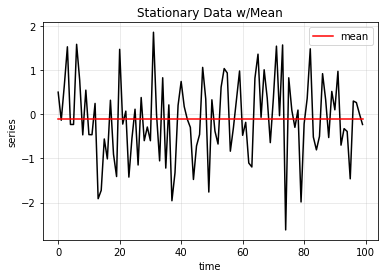

In [5]:
run_sequence_plot(time, stationary,
                  title="Stationary Data w/Mean")
plt.plot(time, sts_avg, 'r', label="mean")
plt.legend();

#### Trend
Add a trend to the stationary data

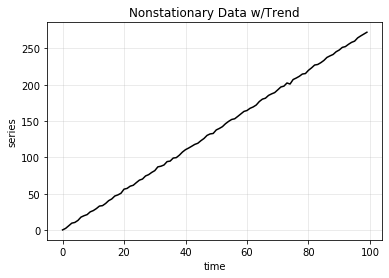

In [17]:
trend = (time * 2.75) + stationary
run_sequence_plot(time, trend,
                  title="Nonstationary Data w/Trend")

It's clear in the plot above that there is an upward trend. Suppose we take the mean of the series again. 

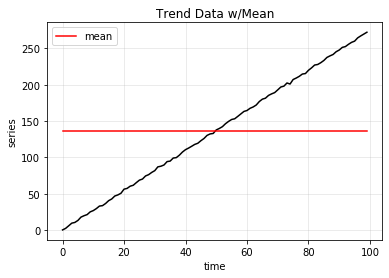

In [18]:
# find mean of series
trend_time_series_avg = np.mean(trend)

# create array of mean value equal to length of time array
trend_avg = np.full(shape=len(time), fill_value=trend_time_series_avg, dtype='float')

run_sequence_plot(time, trend,
                  title="Trend Data w/Mean")
plt.plot(time, trend_avg, 'r', label="mean")
plt.legend();

Therefore, we must find another way to approximate the underlying pattern inherent in the data. There are many ways to capture that trend but let's keep things simple and build up. Let's start with something called a moving average.

### 2. Moving Average Smoothing

The easiest way to understand moving average is by example. 

Say we have the values [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]. 

The first step is to select a window size. We'll choose a size of three arbitrarily. So what happens is we compute the average for the first three values and store the result. We then slide the window over one spot and calculate the average of the next three values. We continue this process until we reach the final observed value. 

Therefore, the window begins with the values [0, 1, 2]. The mean of that sequence is 1 so we store that value [1]. We slide the window over one place to [1, 2, 3] and compute the mean which is 2. We add that value to storage so we have [1, 2]. We continue this process until we reach the last window of size three [7, 8, 9]. We conclude by calculating the mean and storing the result. The result is an array of smoothed values: [1, 2, 3, 4, 5, 6, 7, 8]. 

Compare MSE for the two possibilities we've discussed thus far. 

In [19]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

In [20]:
smoothed_trend = moving_average(trend, window=3, forecast=False)

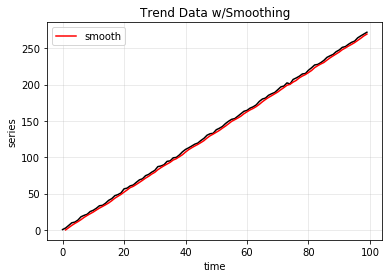

In [21]:
run_sequence_plot(time, trend,
                  title="Trend Data w/Smoothing")
plt.plot(time[1:], np.insert(smoothed_trend,0,0), 'r', label="smooth")
plt.legend();

Not bad at all! You can see the smoothed version picks up the trend rather nicely, far better than the simple average. Now we're getting somewhere.

#### Add seasonality to trend and stationarity

In [22]:
seasonality = 10 + np.sin(time) * 10
smoothed_seasonality = moving_average(seasonality, window=3, forecast=False)

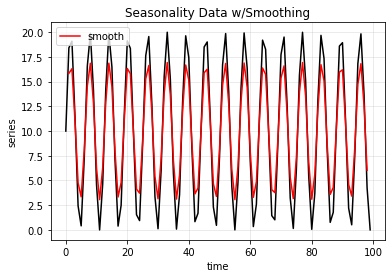

In [23]:
run_sequence_plot(time, seasonality,
                  title="Seasonality Data w/Smoothing")
plt.plot(time[1:-1], smoothed_seasonality, 'r', label="smooth")
plt.legend(loc='upper left');

It's far from perfect but clearly picks up the inherent pattern contained within this seasonal pattern.

Lastly, let's see how moving average handles trend, seasonality, and a bit of noise.

In [24]:
trend_seasonality = trend + seasonality + stationary
smoothed_trend_seasonality = moving_average(trend_seasonality, window=3, forecast=False)

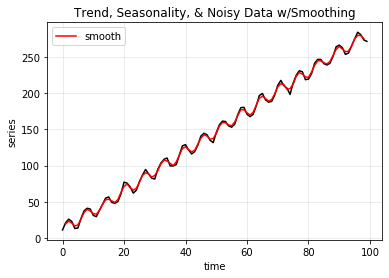

In [25]:
run_sequence_plot(time, trend_seasonality,
                  title="Trend, Seasonality, & Noisy Data w/Smoothing")
plt.plot(time[1:-1], smoothed_trend_seasonality, 'r', label="smooth")
plt.legend(loc='upper left');

Overall this method is doing a decent job on these toy datasets. You can see it's picking up key patterns in the data. However, we've been weighting all observations equally. If you think about time series data, though, you may quickly realize that the most recent observations tend to impact the current to a larger degree than older ones. 

This leads us to another averaging strategy: exponential smoothing.

### 3. Exponential Smoothing
Exponential smoothing is a way to weight observations differently. Specifically, recent observations are weighted moreso than more distant ones. This makes intuitive sense. Think back to the stock market example that we discussed in past lessons. In general, it has been observed that today's price is a good predictor for tomorrow's price. Using an equally weighted smoothing process like the one introduced earlier would dilute that. However, by applying unequal weights to past observations, we can control how much each affects the future forecast. 

#### Three Types of Exponential Smoothing

There are three key exponential smoothing techniques you need to be aware of:
1. Single Exponential Smoothing - no trend or seasonality
 - This method is useful if your data lacks trend and seasonality and you want to approximately track patterns in your data. Furthermore, this method removes the lag associated with the moving average techniques discussed above. 
2. Double Exponential Smoothing - captures trend
 - Should your data exhibit a trend, you'll want to use this smoothing method. It has all the benefits of Single Exponential with the ability to pickup on trend. 
3. Triple Exponential Smoothing - captures trend & seasonality
 - Should your data exhibit trend and seasonality, you'll want to use this smoothing method. It has all the benefits of Double Exponential with the ability to pickup on seasonality. 


### Section 3: Smoothed Time Series in Python

We'll use the same trend and seasonality dataset throughout to compare simple average, single, double, and triple exponential smoothing. 

We'll holdout the last 5 samples from the dataset so we can see how each model makes predictions. We'll then compare those to actuals.

#### Train/Test Split

In [26]:
train = trend_seasonality[:-5]
test = trend_seasonality[-5:]

#### Single Exponential

In [34]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mean_squared_error(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [265.26326384 265.26326384 265.26326384 265.26326384 265.26326384]
MSE:  166.00020327782505


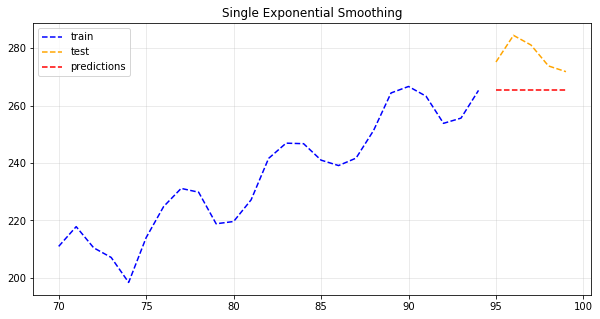

In [31]:
plt.figure(figsize=(10,5))
plt.plot(time[70:-5], train[70:], 'b--', label="train")
plt.plot(time[-5:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-5:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

**Details:** This is certainly better than the simple average method but it's still pretty crude. Notice how the forecast is a horizontal line. Single Exponential Smoothing cannot pickup on trend or seasonality, which harkens back to mean we calculated for the stationary data way back at the beginning.

#### Double Exponential

In [35]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mean_squared_error(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [267.96825996 270.67325607 273.37825219 276.08324831 278.78824442]
MSE:  70.8606684609689


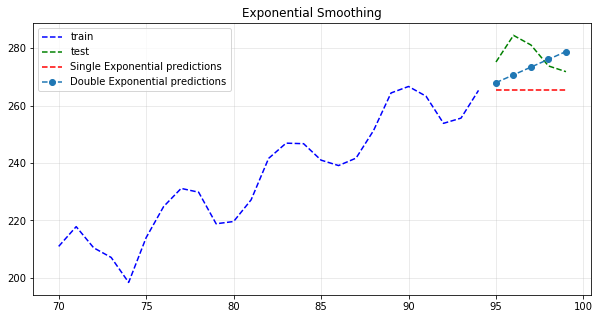

In [30]:
plt.figure(figsize=(10,5))
plt.plot(time[70:-5], train[70:], 'b--', label="train")
plt.plot(time[-5:], test, color='g', linestyle="--", label="test")
plt.plot(time[-5:], single_preds, 'r--', label="Single Exponential predictions")
plt.plot(time[-5:], double_preds, 'o--', label="Double Exponential predictions")
plt.legend(loc='upper left')
plt.title("Exponential Smoothing")
plt.grid(alpha=0.3);

**Details:** Double Exponential Smoothing can pickup on trend, which is exactly what we see here. This is a significant leap but no quite where we need to be.

#### Triple Exponential

In [36]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mean_squared_error(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [275.833281   280.86356813 282.18365704 277.63176504 276.34263682]
MSE:  10.002230057926647


C:\Anaconda3\envs\powlook\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


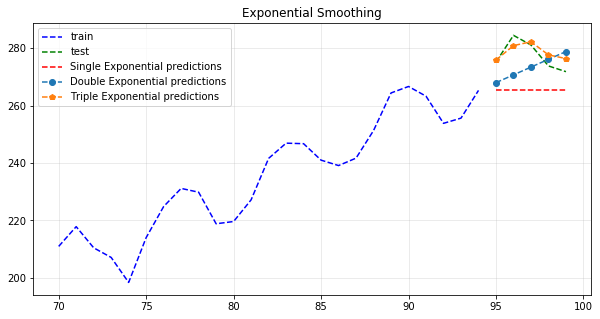

In [33]:
plt.figure(figsize=(10,5))
plt.plot(time[70:-5], train[70:], 'b--', label="train")
plt.plot(time[-5:], test, color='g', linestyle="--", label="test")
plt.plot(time[-5:], single_preds, 'r--', label="Single Exponential predictions")
plt.plot(time[-5:], double_preds, 'o--', label="Double Exponential predictions")
plt.plot(time[-5:], triple_preds, 'p--', label="Triple Exponential predictions")
plt.legend(loc='upper left')
plt.title("Exponential Smoothing")
plt.grid(alpha=0.3);

**Details:** Triple Exponential Smoothing pickups trend and seasonality. This is clear in the plot above. This approach makes the most sense for this data.

#### Comparison

In [39]:
data_dict = {'MSE':[single_mse, double_mse, triple_mse]}
df = pd.DataFrame(data_dict, index=['single', 'double', 'triple'])
print(df)

               MSE
single  166.000203
double   70.860668
triple   10.002230
